## Setup

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10.0, 8.0), 'image.interpolation': 'nearest', 'image.cmap': 'gray'})

def display_grid(imgs):
    flat_imgs = imgs.view(imgs.size(0), -1).detach().cpu().numpy()
    grid_size = int(np.ceil(np.sqrt(flat_imgs.shape[0])))
    img_dim = int(np.ceil(np.sqrt(flat_imgs.shape[1])))

    fig = plt.figure(figsize=(grid_size, grid_size))
    grid = gridspec.GridSpec(grid_size, grid_size, wspace=0.05, hspace=0.05)

    for idx, image in enumerate(flat_imgs):
        ax = plt.subplot(grid[idx])
        ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        plt.imshow(image.reshape(img_dim, img_dim))
    plt.show()

normalize_data = lambda data: 2 * data - 1.0
denormalize_data = lambda data: (data + 1.0) / 2.0

def compute_relative_error(a, b):
    return np.max(np.abs(a - b) / np.maximum(1e-8, np.abs(a) + np.abs(b)))

def get_trainable_params(net):
    return sum(param.numel() for param in net.parameters() if param.requires_grad)

## Dataset

In [17]:
data_transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST('./data', train=True, download=True, transform=data_transform)
data_loader = DataLoader(train_data, batch_size=16, shuffle=False)

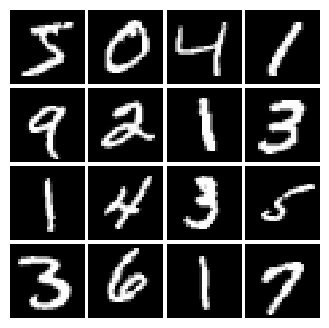

In [18]:
batch_iterator = iter(data_loader)
batch_imgs, batch_targets = next(batch_iterator)
display_grid(batch_imgs)

## Encoder

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

INPUT_SIZE = batch_imgs[0].numel()
sample_count = 100000
display_count = 100

epochs = 10
train_batch_size = 128
LATENT_DIM = 20
lr = 1e-3

class VariationalEncoder(nn.Module):
    def __init__(self, latent_size=LATENT_DIM, input_size=INPUT_SIZE):
        super(VariationalEncoder, self).__init__()
        self.latent_size = latent_size
        self.input_size = input_size
        self.hidden_layer = nn.Linear(input_size, 400)
        self.output_layer = nn.Linear(400, latent_size * 2)

    def forward(self, data):
        hidden = F.relu(self.hidden_layer(data))
        combined = self.output_layer(hidden)
        mean, logvar = combined[:, :self.latent_size], combined[:, self.latent_size:]
        return mean, logvar

In [20]:
def reparameterize(mean, logvar):
    noise = torch.randn_like(mean)
    sigma = torch.exp(0.5 * logvar)
    return mean + sigma * noise

## Decoder

In [21]:
class VariationalDecoder(nn.Module):
    def __init__(self, latent_size=LATENT_DIM, output_size=INPUT_SIZE):
        super(VariationalDecoder, self).__init__()
        self.expand_layer = nn.Linear(latent_size, 400)
        self.reconstruct_layer = nn.Linear(400, output_size)

    def forward(self, latent):
        expanded = F.relu(self.expand_layer(latent))
        reconstruction_logits = self.reconstruct_layer(expanded)
        return reconstruction_logits

## Loss definition

In [22]:
def compute_vae_loss(original, reconstructed_logits, latent_mean, latent_logvar):
    reconstruction_error = None
    divergence_loss = None

    reconstruction_error = F.binary_cross_entropy_with_logits(reconstructed_logits, original, reduction='none').sum(dim=1)
    divergence_loss = -0.5 * torch.sum(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp(), dim=1)
    total_loss = torch.mean(reconstruction_error + divergence_loss)
    return total_loss, torch.mean(reconstruction_error)

## Optimizing loss


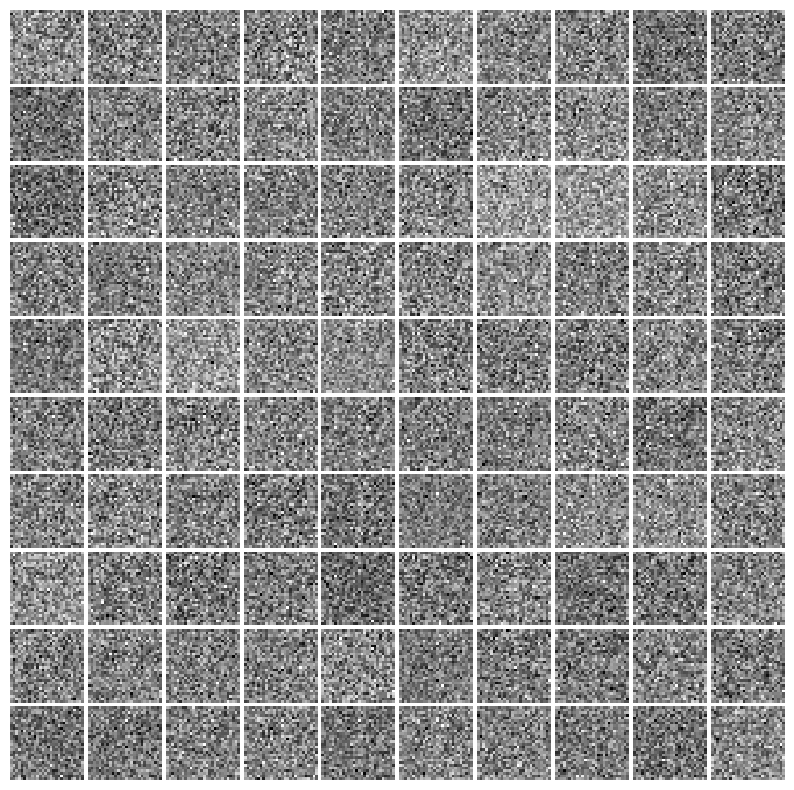

In [23]:
compute_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_net = VariationalEncoder().to(compute_device)
decoder_net = VariationalDecoder().to(compute_device)

vae_optimizer = torch.optim.Adam(list(encoder_net.parameters()) + list(decoder_net.parameters()), lr=lr)

preprocessing = transforms.Compose([transforms.ToTensor()])
training_dataset = datasets.MNIST('./data', train=True, download=True, transform=preprocessing)
training_loader = DataLoader(training_dataset, batch_size=train_batch_size, shuffle=True)

sample_latent = torch.randn(display_count, LATENT_DIM).to(compute_device)
generated_logits = decoder_net(sample_latent)
generated_images = torch.sigmoid(generated_logits).detach().cpu()
display_grid(generated_images)
plt.show()

## Training

In [24]:
step_counter = 0
log_interval = 200

for training_epoch in range(epochs):
    for batch_data, _ in training_loader:
        flattened_batch = batch_data.view(batch_data.size(0), -1).to(compute_device)

        latent_mean, latent_logvar = encoder_net(normalize_data(flattened_batch))
        sampled_latent = reparameterize(latent_mean, latent_logvar)
        reconstruction_logits = decoder_net(sampled_latent)

        total_loss, reconstruction_loss = compute_vae_loss(flattened_batch, reconstruction_logits, latent_mean, latent_logvar)

        vae_optimizer.zero_grad()
        total_loss.backward()
        vae_optimizer.step()

        if step_counter % log_interval == 0:
            print(f'Epoch: {training_epoch}, Iter: {step_counter}, Loss: {total_loss.item():.4f}, Recon: {reconstruction_loss.item():.4f}')
        step_counter += 1

Epoch: 0, Iter: 0, Loss: 549.7648, Recon: 549.1089
Epoch: 0, Iter: 200, Loss: 142.0776, Recon: 123.6306
Epoch: 0, Iter: 400, Loss: 128.8935, Recon: 107.3987
Epoch: 1, Iter: 600, Loss: 120.9829, Recon: 98.3896
Epoch: 1, Iter: 800, Loss: 117.0622, Recon: 92.9885
Epoch: 2, Iter: 1000, Loss: 114.0792, Recon: 90.3537
Epoch: 2, Iter: 1200, Loss: 112.5104, Recon: 89.1889
Epoch: 2, Iter: 1400, Loss: 113.9088, Recon: 89.9358
Epoch: 3, Iter: 1600, Loss: 116.5202, Recon: 91.5570
Epoch: 3, Iter: 1800, Loss: 113.1227, Recon: 89.4352
Epoch: 4, Iter: 2000, Loss: 109.3718, Recon: 84.9840
Epoch: 4, Iter: 2200, Loss: 109.6774, Recon: 85.7281
Epoch: 5, Iter: 2400, Loss: 112.5803, Recon: 87.5277
Epoch: 5, Iter: 2600, Loss: 107.8778, Recon: 83.0327
Epoch: 5, Iter: 2800, Loss: 111.6634, Recon: 87.2149
Epoch: 6, Iter: 3000, Loss: 106.1806, Recon: 81.8678
Epoch: 6, Iter: 3200, Loss: 111.4930, Recon: 86.4166
Epoch: 7, Iter: 3400, Loss: 111.4703, Recon: 86.6264
Epoch: 7, Iter: 3600, Loss: 108.1379, Recon: 83.93

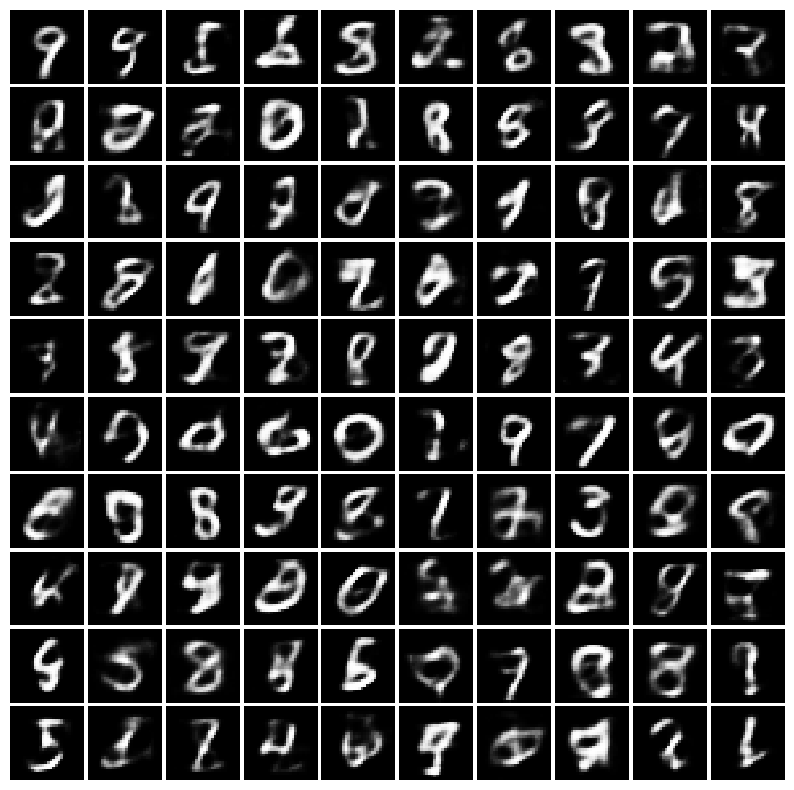

In [25]:
random_latent = torch.randn(display_count, LATENT_DIM).to(compute_device)
final_outputs = decoder_net(random_latent)
final_images = torch.sigmoid(final_outputs).detach().cpu()
display_grid(final_images)
plt.show()

## Inception score for trained VAE model

In [27]:
classifier_batch_size = 128
category_count = 10
training_epochs = 20

train_data = datasets.MNIST('./data', train=True, download=True, transform=preprocessing)
eval_data = datasets.MNIST('./data', train=False, download=True, transform=preprocessing)

train_batches = DataLoader(train_data, batch_size=classifier_batch_size, shuffle=True)
eval_batches = DataLoader(eval_data, batch_size=classifier_batch_size)

print(f'{len(train_data)} train samples')
print(f'{len(eval_data)} test samples')

class NeuralNetClassifier(nn.Module):
    def __init__(self):
        super(NeuralNetClassifier, self).__init__()
        self.layer1 = nn.Linear(784, 512)
        self.layer2 = nn.Linear(512, 512)
        self.output_layer = nn.Linear(512, category_count)

    def forward(self, data):
        data = torch.flatten(data, start_dim=1)
        data = F.relu(self.layer1(data))
        data = F.dropout(data, 0.2)
        data = F.relu(self.layer2(data))
        data = F.dropout(data, 0.2)
        data = self.output_layer(data)
        return data

    def prob(self, data):
        data = self.forward(data)
        probabilities = F.softmax(data, dim=-1)
        return probabilities

classifier = NeuralNetClassifier().to(compute_device)
classifier_optimizer = optim.RMSprop(classifier.parameters(), lr=0.001, alpha=0.9)
loss_function = nn.CrossEntropyLoss()

for epoch_num in range(training_epochs):
    classifier.train()
    for data_batch, target_batch in train_batches:
        data_batch = data_batch.to(compute_device)
        target_batch = target_batch.to(compute_device)
        classifier_optimizer.zero_grad()
        predictions = classifier(data_batch)
        batch_loss = loss_function(predictions, target_batch)
        batch_loss.backward()
        classifier_optimizer.step()
    print(f'Epoch {epoch_num+1}/{training_epochs}, Loss: {batch_loss.item():.4f}')

classifier.eval()
accurate_predictions = 0
total_samples = 0
with torch.no_grad():
    for data_batch, target_batch in eval_batches:
        data_batch = data_batch.to(compute_device)
        target_batch = target_batch.to(compute_device)
        predictions = classifier(data_batch)
        predicted_classes = torch.argmax(predictions, dim=1)
        total_samples += target_batch.size(0)
        accurate_predictions += (predicted_classes == target_batch).sum().item()

print('Test accuracy:', accurate_predictions / total_samples)

60000 train samples
10000 test samples
Epoch 1/20, Loss: 0.1094
Epoch 2/20, Loss: 0.0735
Epoch 3/20, Loss: 0.1443
Epoch 4/20, Loss: 0.0055
Epoch 5/20, Loss: 0.0123
Epoch 6/20, Loss: 0.0447
Epoch 7/20, Loss: 0.0031
Epoch 8/20, Loss: 0.0216
Epoch 9/20, Loss: 0.0142
Epoch 10/20, Loss: 0.0185
Epoch 11/20, Loss: 0.0077
Epoch 12/20, Loss: 0.0020
Epoch 13/20, Loss: 0.0002
Epoch 14/20, Loss: 0.0014
Epoch 15/20, Loss: 0.0031
Epoch 16/20, Loss: 0.0716
Epoch 17/20, Loss: 0.0011
Epoch 18/20, Loss: 0.0474
Epoch 19/20, Loss: 0.0143
Epoch 20/20, Loss: 0.0009
Test accuracy: 0.9781


### Verify the trained classifier on the generated samples

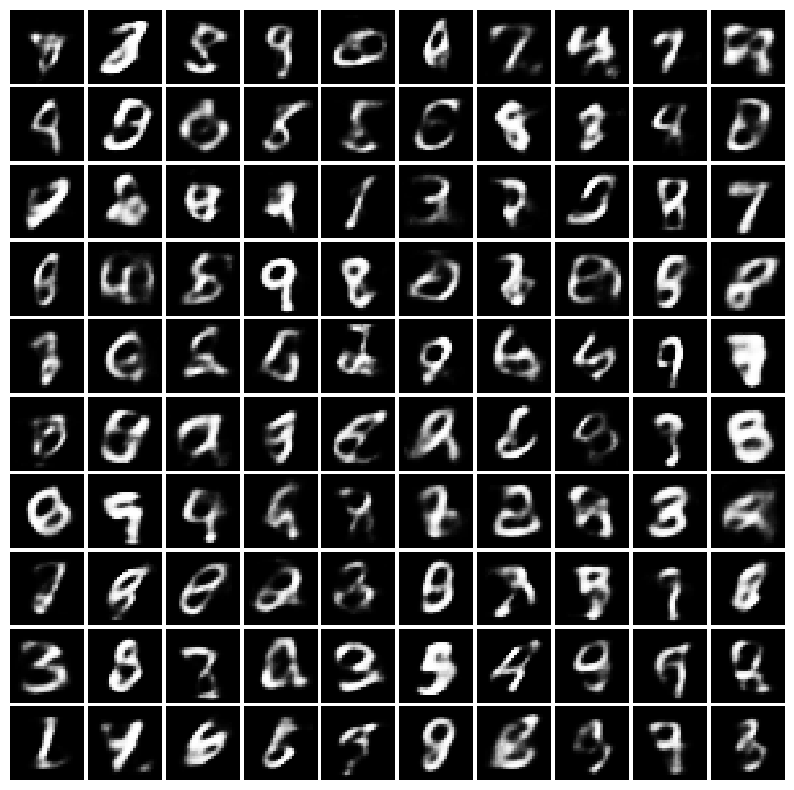

In [28]:
bulk_latent = torch.randn(sample_count, LATENT_DIM).to(compute_device)
bulk_outputs = decoder_net(bulk_latent)
display_samples = torch.sigmoid(bulk_outputs[:display_count]).detach().cpu()
display_grid(display_samples)
plt.show()

## Implement the inception score

In [29]:
with torch.no_grad():
    quality_metric = None

    class_probabilities = classifier.prob(torch.sigmoid(bulk_outputs))
    marginal_distribution = torch.mean(class_probabilities, dim=0)
    divergence = class_probabilities * (torch.log(class_probabilities + 1e-16) - torch.log(marginal_distribution.unsqueeze(0) + 1e-16))
    quality_metric = torch.exp(torch.mean(torch.sum(divergence, dim=1))).item()

print(f'Inception score: {quality_metric:.4f}')

Inception score: 7.4628
